# Get dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
from google.colab import userdata
api_key = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.13.0.90
    Uninstalling opencv-python-headless-4.13.0.90:
      Successfully uninstalled opencv-python-headless-4.13.0.90
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
project = rf.workspace("hrbialik18").project("weld-nuts-top-down")
version = project.version(1)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weld-Nuts-Top-Down-1 in coco-segmentation:: 100%|██████████| 58/58 [00:00<00:00, 6247.61it/s]


# Creating the masks

##Train

**High-level goal**

Reads a COCO-format annotation file

Extracts segmentation masks for Metal-Nuts

Converts each nut instance into a distance transform

Combines all instances in an image into one distance map

Saves that distance map as a grayscale image

So instead of a binary mask, you get a smooth map where:

- pixels at the center of a nut ≈ 1 (255)

- pixels near the boundary ≈ 0

- background = 0

This is great for instance-aware training, watershed, center-based losses, etc.

In [ ]:
import json
import numpy as np
from pycocotools import mask as maskUtils
from PIL import Image
import os
import cv2

coco_json_path = "/content/Weld-Nuts-Top-Down-1/train/_annotations.coco.json"
mask_dir = "masks_train/"

os.makedirs(mask_dir, exist_ok=True)

with open(coco_json_path) as f:
    coco = json.load(f)

cat_map = {cat['name']: cat['id'] for cat in coco['categories']}
nuts_id = cat_map['Metal-Nuts']

print(cat_map)

# Pre-group annotations by image_id (much faster)
annos_by_image = {}
for ann in coco['annotations']:
    if ann['category_id'] != nuts_id:
        continue
    annos_by_image.setdefault(ann['image_id'], []).append(ann)

for img in coco['images']:
    img_id = img['id']
    h, w = img['height'], img['width']

    # Final distance-map target
    dist_map = np.zeros((h, w), dtype=np.float32)

    annos = annos_by_image.get(img_id, [])

    for ann in annos:
        seg = ann['segmentation']

        # Decode instance mask
        if isinstance(seg, list):  # polygon
            rle = maskUtils.frPyObjects(seg, h, w)
            m = maskUtils.decode(rle)
            if m.ndim == 3:
                m = np.any(m, axis=2)
        else:  # RLE
            m = maskUtils.decode(seg)

        m = m.astype(np.uint8)

        if m.sum() == 0:
            continue

        # Distance transform for THIS INSTANCE
        d = cv2.distanceTransform(m, cv2.DIST_L2, 5)

        # Normalize per instance
        if d.max() > 0:
            d = d / d.max()

        # Merge instances by max
        dist_map = np.maximum(dist_map, d)

    # Save as 8-bit (0–255) for compatibility
    dist_img = Image.fromarray((dist_map * 255).astype(np.uint8))
    filename = os.path.basename(img['file_name'])
    dist_img.save(os.path.join(mask_dir, filename))


{'Metal-Nuts': 1}


##Test

In [ ]:
import json
import numpy as np
from pycocotools import mask as maskUtils
from PIL import Image
import os
import cv2

coco_json_path = "/content/Weld-Nuts-Top-Down-1/test/_annotations.coco.json"
mask_dir = "masks_test/"

os.makedirs(mask_dir, exist_ok=True)

with open(coco_json_path) as f:
    coco = json.load(f)

cat_map = {cat['name']: cat['id'] for cat in coco['categories']}
nuts_id = cat_map['Metal-Nuts']

print(cat_map)

# Pre-group annotations by image_id (much faster)
annos_by_image = {}
for ann in coco['annotations']:
    if ann['category_id'] != nuts_id:
        continue
    annos_by_image.setdefault(ann['image_id'], []).append(ann)

for img in coco['images']:
    img_id = img['id']
    h, w = img['height'], img['width']

    # Final distance-map target
    dist_map = np.zeros((h, w), dtype=np.float32)

    annos = annos_by_image.get(img_id, [])

    for ann in annos:
        seg = ann['segmentation']

        # Decode instance mask
        if isinstance(seg, list):  # polygon
            rle = maskUtils.frPyObjects(seg, h, w)
            m = maskUtils.decode(rle)
            if m.ndim == 3:
                m = np.any(m, axis=2)
        else:  # RLE
            m = maskUtils.decode(seg)

        m = m.astype(np.uint8)

        if m.sum() == 0:
            continue

        # Distance transform for THIS INSTANCE
        d = cv2.distanceTransform(m, cv2.DIST_L2, 5)

        # Normalize per instance
        if d.max() > 0:
            d = d / d.max()

        # Merge instances by max
        dist_map = np.maximum(dist_map, d)

    # Save as 8-bit (0–255) for compatibility
    dist_img = Image.fromarray((dist_map * 255).astype(np.uint8))
    filename = os.path.basename(img['file_name'])
    dist_img.save(os.path.join(mask_dir, filename))


{'Metal-Nuts': 1}


#Train the Model

In [ ]:
class BoundaryWeightedMSE(nn.Module):
    def __init__(self, boundary_weight=5.0):
        super().__init__()
        self.boundary_weight = boundary_weight

    def forward(self, pred, target):
        # Compute gradient magnitude of target distance map
        # High at boundaries, low in interior
        grad_x = target[:, :, :, 1:] - target[:, :, :, :-1]
        grad_y = target[:, :, 1:, :] - target[:, :, :-1, :]

        # Pad to match original size
        grad_x = torch.nn.functional.pad(grad_x, (0, 1, 0, 0))
        grad_y = torch.nn.functional.pad(grad_y, (0, 0, 0, 1))

        grad_magnitude = torch.sqrt(grad_x**2 + grad_y**2 + 1e-8)

        # Normalize to [0, 1]
        grad_magnitude = (grad_magnitude - grad_magnitude.min()) / \
                        (grad_magnitude.max() - grad_magnitude.min() + 1e-8)

        # Weight map: 1.0 + extra weight at boundaries
        weight_map = 1.0 + self.boundary_weight * grad_magnitude

        # Weighted MSE
        mse = (pred - target) ** 2
        weighted_mse = (weight_map * mse).mean()

        return weighted_mse

In [ ]:
class MSEGradientLoss(nn.Module):
    def __init__(self, mse_weight=1.0, grad_weight=2.0):
        super().__init__()
        self.mse_weight = mse_weight
        self.grad_weight = grad_weight

    def forward(self, pred, target):
        # Standard MSE
        mse_loss = nn.functional.mse_loss(pred, target)

        # Gradient matching - preserves sharp transitions
        pred_grad_x = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        pred_grad_y = pred[:, :, 1:, :] - pred[:, :, :-1, :]

        target_grad_x = target[:, :, :, 1:] - target[:, :, :, :-1]
        target_grad_y = target[:, :, 1:, :] - target[:, :, :-1, :]

        # L1 loss on gradients (more robust than L2)
        grad_loss = (torch.abs(pred_grad_x - target_grad_x).mean() +
                     torch.abs(pred_grad_y - target_grad_y).mean())

        return self.mse_weight * mse_loss + self.grad_weight * grad_loss

In [ ]:
# =========================
# U-NET TRAINING (DISTANCE MAP)
# =========================

# ---- Imports ----
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# ---- Paths ----
IMG_DIR = "/content/Weld-Nuts-Top-Down-1/train/"
MASK_DIR = "/content/masks_train"  # distance-map masks

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Dataset ----
class NutDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]

        img_path = os.path.join(self.img_dir, name)
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask_path = os.path.join(self.mask_dir, name)
        if not os.path.exists(mask_path):
            raise FileNotFoundError(mask_path)

        # ---- CHANGED: load distance map (0–1 float) ----
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask.astype(np.float32) / 255.0  # distance target

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"]

        return img, mask.unsqueeze(0)

# ---- Transforms ----
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])

# ---- DataLoader ----
dataset = NutDataset(IMG_DIR, MASK_DIR, transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

# ---- U-Net (UNCHANGED) ----
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bridge = DoubleConv(512, 1024)

        self.u4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.c4 = DoubleConv(1024, 512)

        self.u3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.c3 = DoubleConv(512, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = DoubleConv(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        d3 = self.d3(self.pool(d2))
        d4 = self.d4(self.pool(d3))

        b = self.bridge(self.pool(d4))

        x = self.u4(b)
        x = self.c4(torch.cat([x, d4], 1))
        x = self.u3(x)
        x = self.c3(torch.cat([x, d3], 1))
        x = self.u2(x)
        x = self.c2(torch.cat([x, d2], 1))
        x = self.u1(x)
        x = self.c1(torch.cat([x, d1], 1))

        return self.out(x)

# ---- CHANGED: Regression loss ----
model = UNet().to(DEVICE)

loss_fn = BoundaryWeightedMSE(boundary_weight=5.0).to(DEVICE) #nn.L1Loss()   # or nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# def boundary_weighted_l1(pred, mask, alpha=3.0, beta=0.5):
#     """
#     pred:  (B,1,H,W) prediction in [0,1]
#     mask:  (B,1,H,W) GT distance map in [0,1]
#     alpha: boundary boost
#     beta:  foreground (nut) boost
#     """

#     l1 = torch.abs(pred - mask)

#     # Foreground: nut interior + boundary
#     fg = (mask > 0).float()

#     # Weight map
#     weight = (
#         1.0                      # base (background)
#         + beta * fg              # boost all nut pixels (center INCLUDED)
#         + alpha * (1 - mask) * fg  # extra boost near boundaries
#     )

#     return (l1 * weight).mean()

# ---- Training ----
EPOCHS = 70

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, masks in loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        preds = model(imgs)
        preds = torch.sigmoid(preds)  # constrain to [0,1]

        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(loader):.4f}")

Epoch 1/70 | Loss: 0.2963
Epoch 2/70 | Loss: 0.2676
Epoch 3/70 | Loss: 0.2473
Epoch 4/70 | Loss: 0.2296
Epoch 5/70 | Loss: 0.2106
Epoch 6/70 | Loss: 0.1877
Epoch 7/70 | Loss: 0.1735
Epoch 8/70 | Loss: 0.1599
Epoch 9/70 | Loss: 0.1494
Epoch 10/70 | Loss: 0.1399
Epoch 11/70 | Loss: 0.1385
Epoch 12/70 | Loss: 0.1345
Epoch 13/70 | Loss: 0.1280
Epoch 14/70 | Loss: 0.1223
Epoch 15/70 | Loss: 0.1187
Epoch 16/70 | Loss: 0.1153
Epoch 17/70 | Loss: 0.1132
Epoch 18/70 | Loss: 0.1102
Epoch 19/70 | Loss: 0.1078
Epoch 20/70 | Loss: 0.1051
Epoch 21/70 | Loss: 0.1026
Epoch 22/70 | Loss: 0.1001
Epoch 23/70 | Loss: 0.0981
Epoch 24/70 | Loss: 0.0974
Epoch 25/70 | Loss: 0.0961
Epoch 26/70 | Loss: 0.0934
Epoch 27/70 | Loss: 0.0919
Epoch 28/70 | Loss: 0.0902
Epoch 29/70 | Loss: 0.0883
Epoch 30/70 | Loss: 0.0867
Epoch 31/70 | Loss: 0.0853
Epoch 32/70 | Loss: 0.0850
Epoch 33/70 | Loss: 0.0831
Epoch 34/70 | Loss: 0.0823
Epoch 35/70 | Loss: 0.0798
Epoch 36/70 | Loss: 0.0782
Epoch 37/70 | Loss: 0.0765
Epoch 38/7

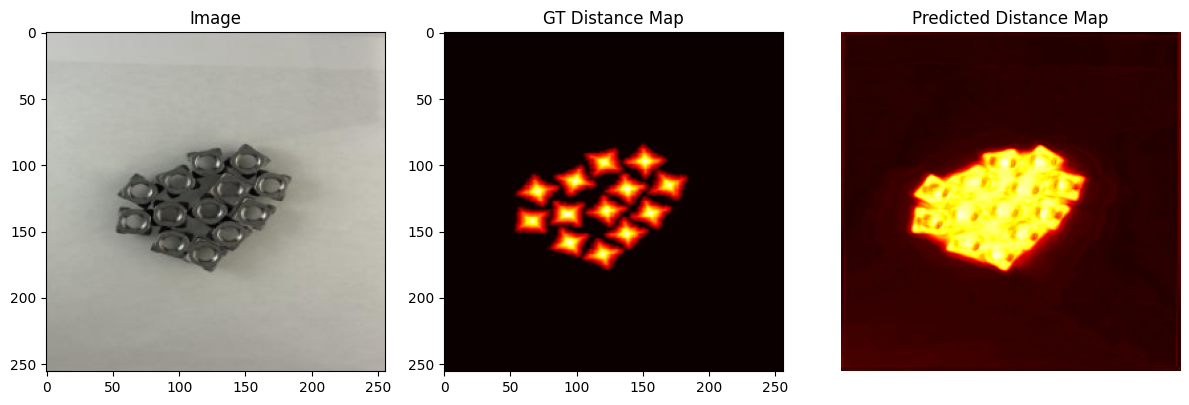

In [ ]:
# ---- Sanity check (DISTANCE MAP) ----
model.eval()
img, gt = dataset[1]

with torch.no_grad():
    pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))


pred_map = pred[0, 0].cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(gt[0], cmap="hot")
plt.title("GT Distance Map")

plt.subplot(1,3,3)
plt.imshow(pred_map, cmap="hot")
plt.title("Predicted Distance Map")

plt.axis("off")
plt.tight_layout()
plt.show()

#Test the model

Evaluating 12 images...


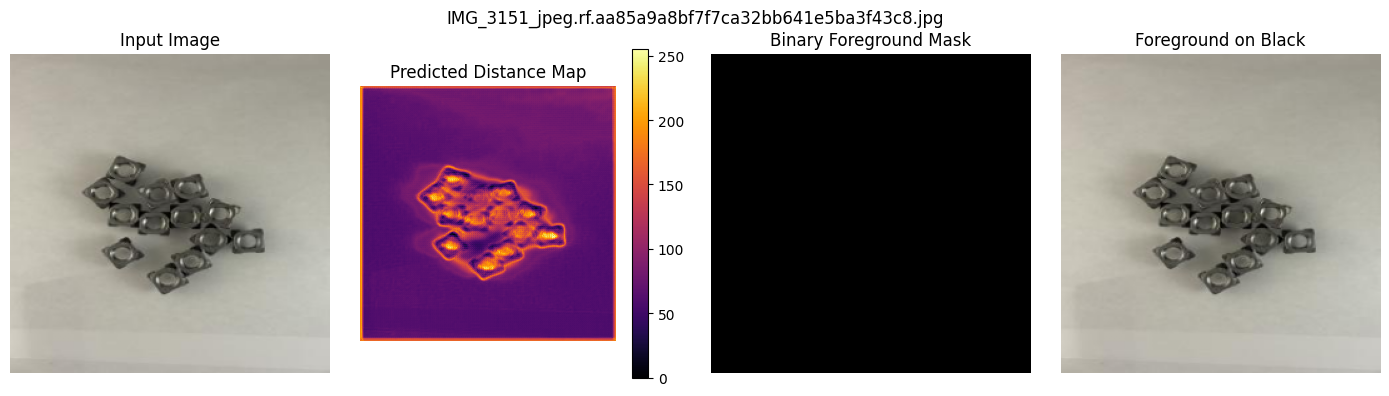

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

model.eval()

# ---------------- CONFIG ----------------
VISUALIZE = True          # 🔥 toggle visualization
MAX_VIS = 12              # limit number of images shown
# ---------------------------------------

# Paths
test_img_dir = "/content/Weld-Nuts-Top-Down-1/test"
output_dir = "/content/cutouts"

os.makedirs(output_dir, exist_ok=True)

img_files = [
    f for f in os.listdir(test_img_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

infer_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])

print(f"Evaluating {len(img_files)} images...")

vis_count = 0

for img_file in img_files:
    # ---- Load image ----
    img_path = os.path.join(test_img_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = infer_tf(image=img)
    img_tensor = tf["image"]

    # ---- Predict distance map ----
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0).to(DEVICE))
        dist = torch.sigmoid(pred)[0, 0].cpu().numpy()

    # ---- Threshold to get foreground ----
    _, fg = cv2.threshold(dist, 0.15, 1.0, cv2.THRESH_BINARY)
    fg = (fg * 255).astype(np.uint8)

    kernel = np.ones((3, 3), np.uint8)
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel)

    # ---- Apply foreground mask to original image ----
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    fg_mask = fg.astype(bool)

    foreground_only = img_np.copy()
    foreground_only[~fg_mask] = 0

    # ---- Save result ----
    out_name = f"{os.path.splitext(img_file)[0]}_foreground.png"
    out_img = (foreground_only * 255).astype(np.uint8)
    out_bgr = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, out_name), out_bgr)

if VISUALIZE and vis_count < MAX_VIS:
    vis_count += 1

    dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(dist_norm, cmap="inferno")
    plt.title("Predicted Distance Map")
    plt.colorbar()
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(fg, cmap="gray")
    plt.title("Binary Foreground Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(foreground_only)
    plt.title("Foreground on Black")
    plt.axis("off")

    plt.suptitle(img_file)
    plt.tight_layout()
    plt.show()


Evaluating 12 images...


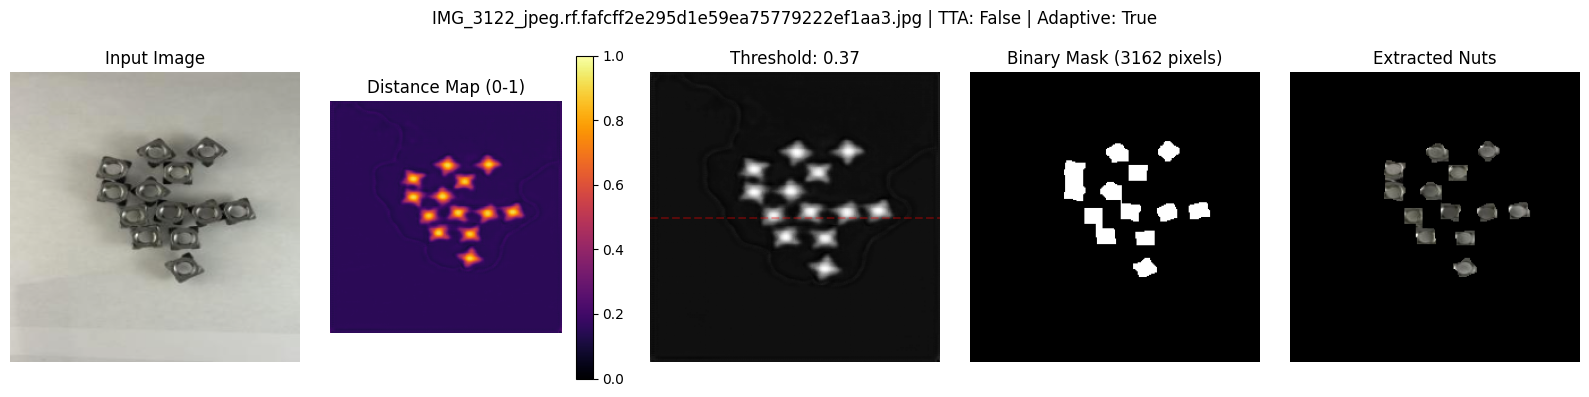

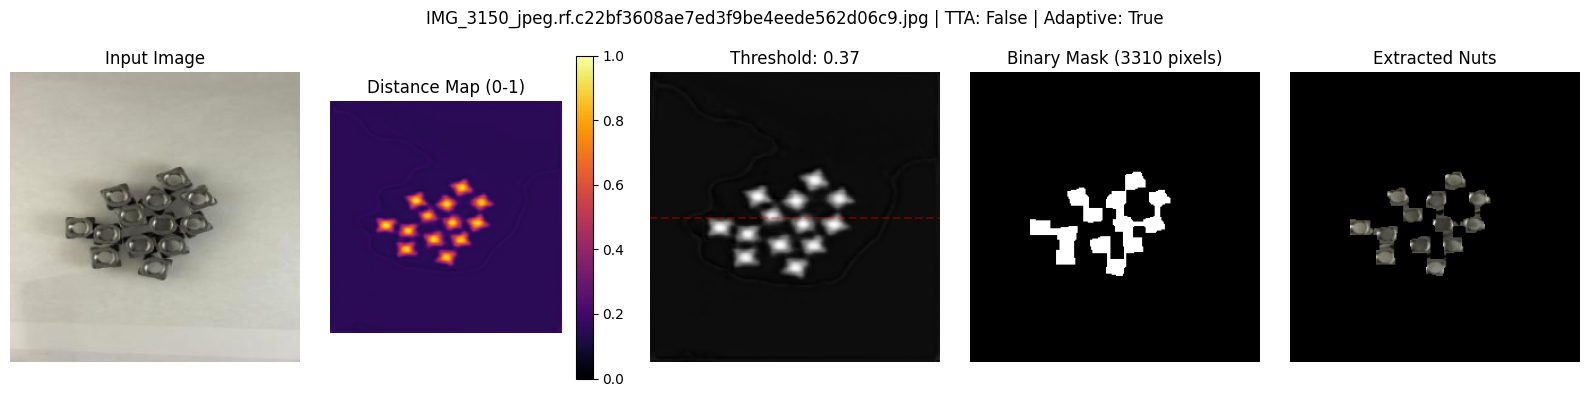

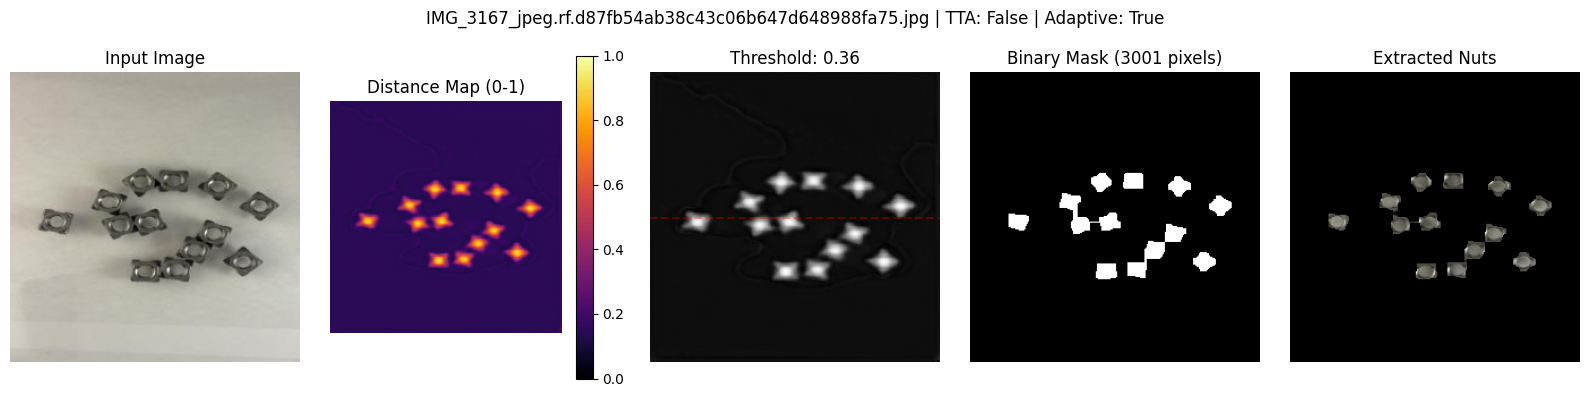

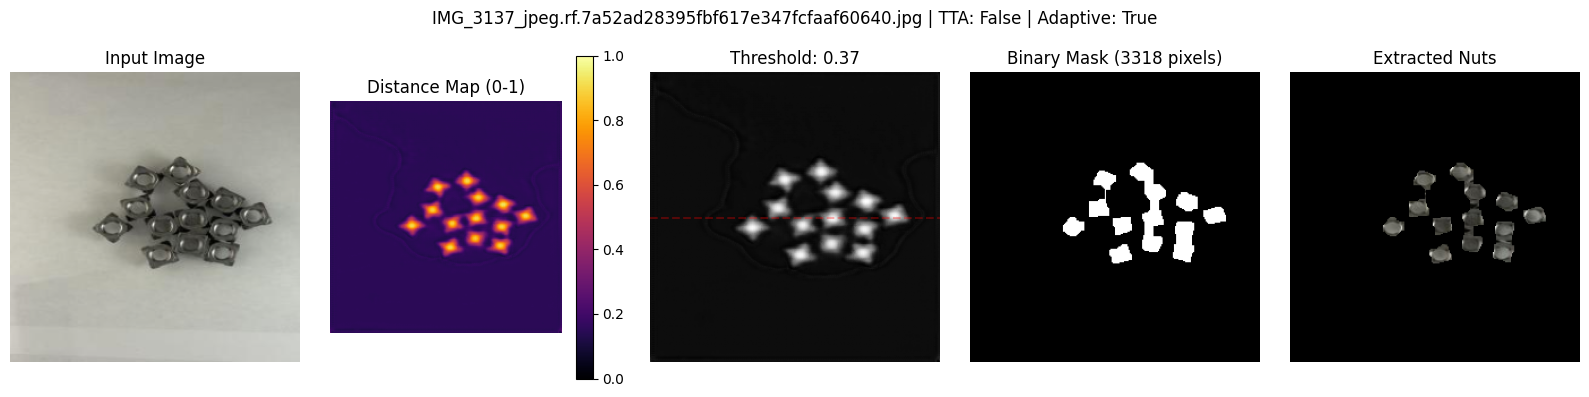

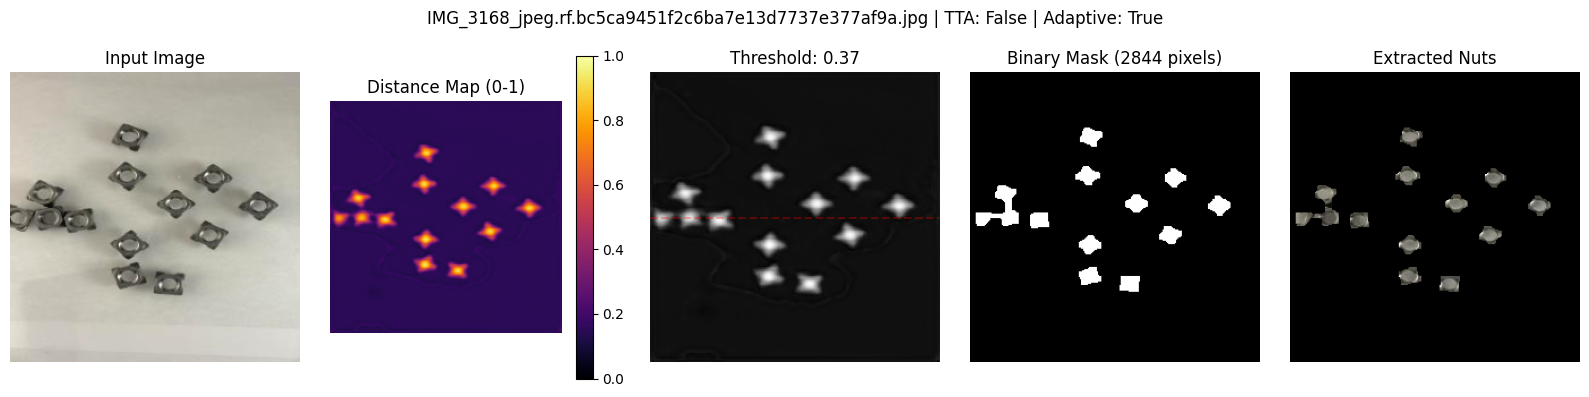

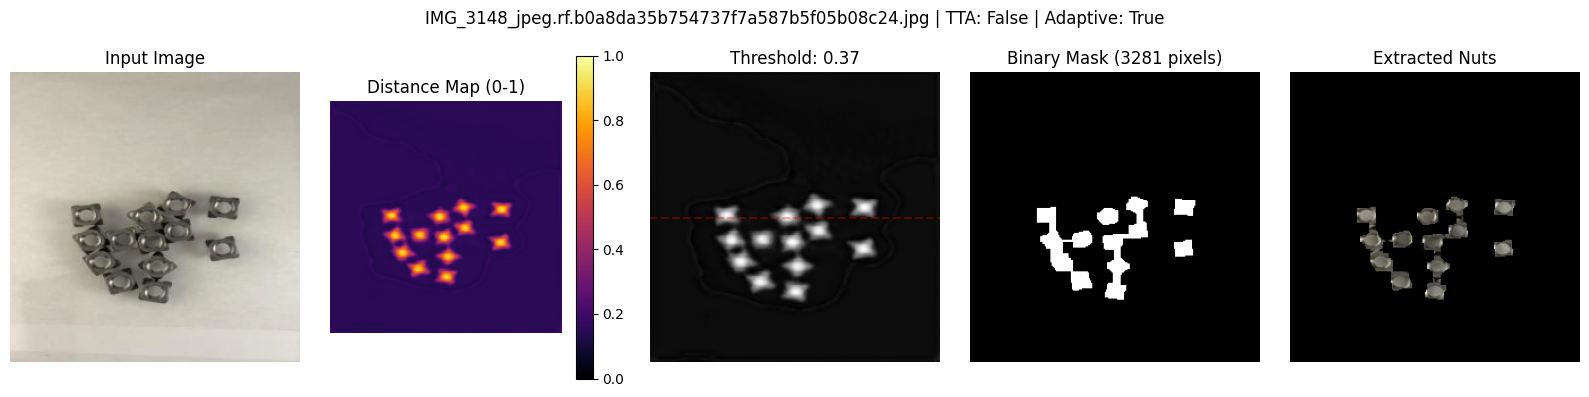

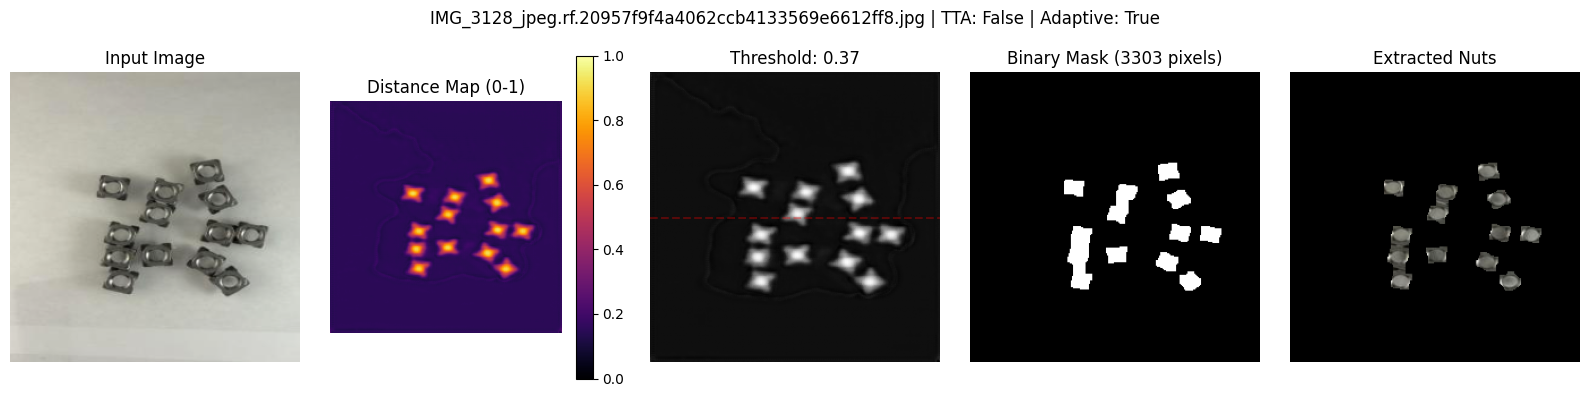

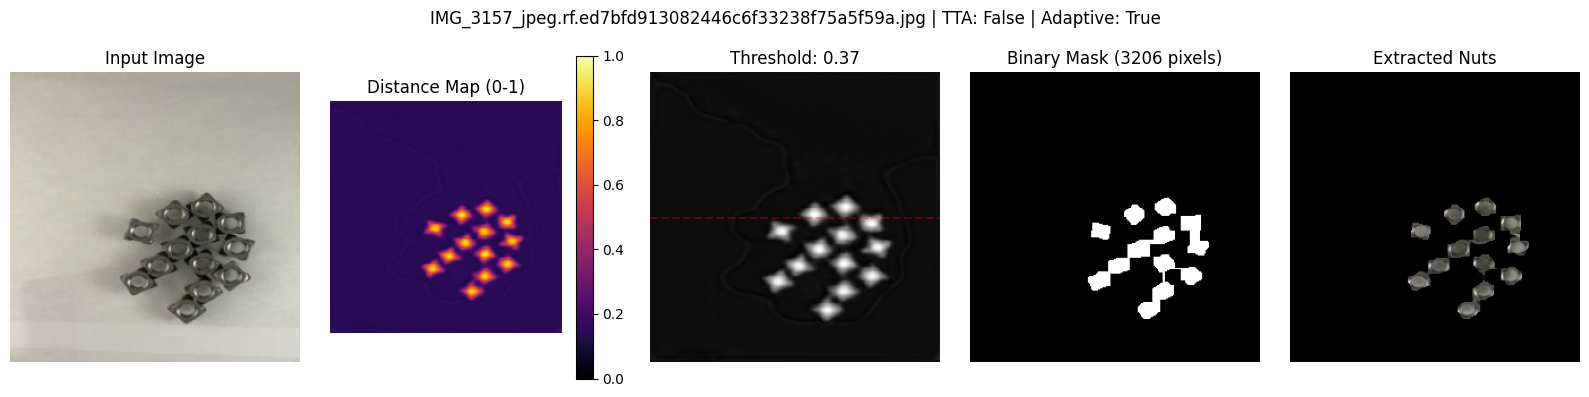

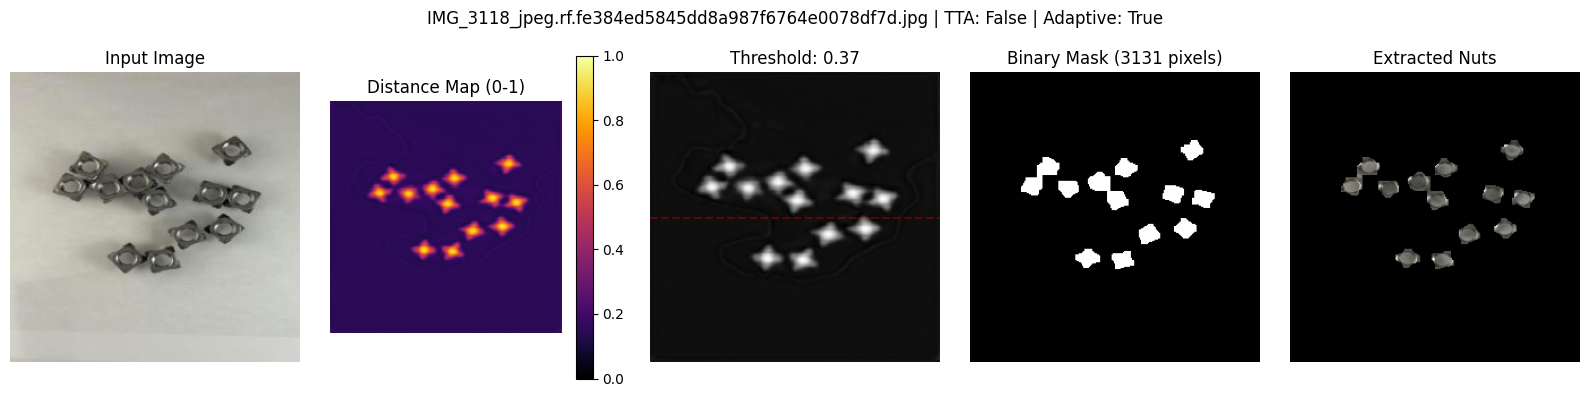

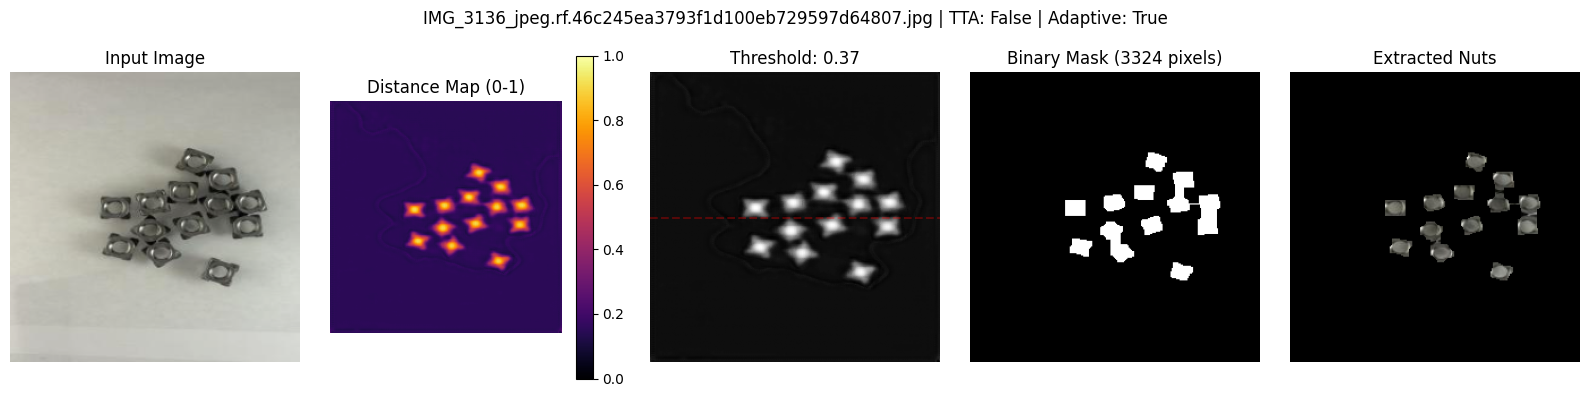

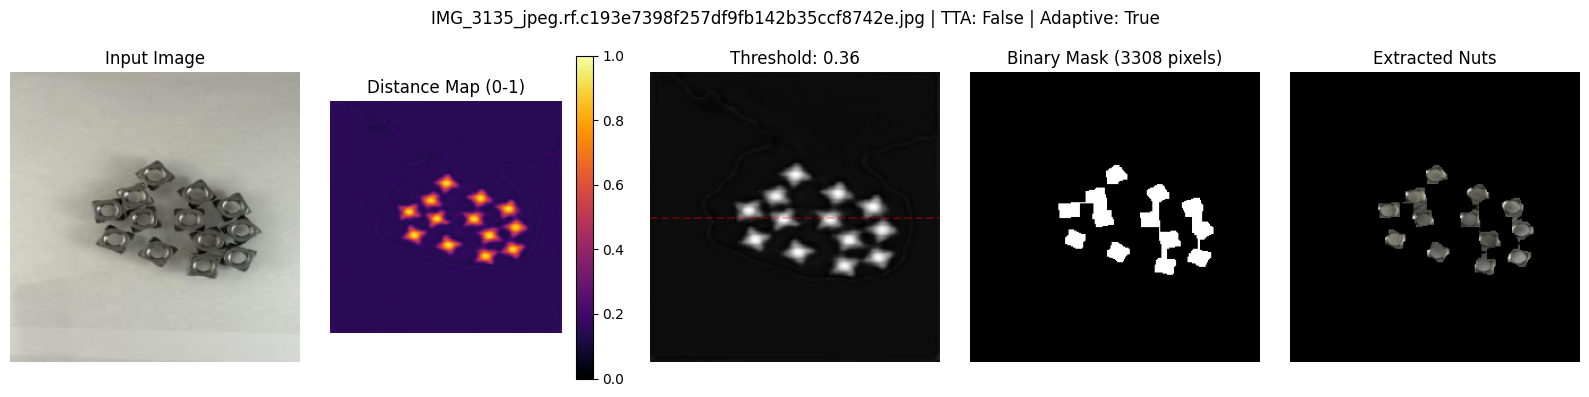

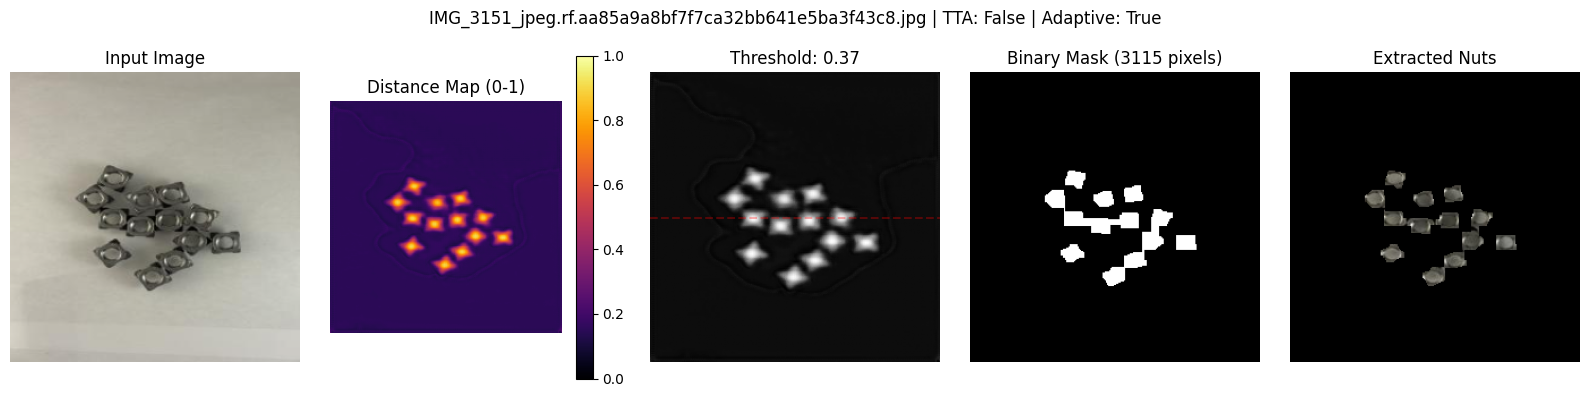


✓ Processed 12 images
✓ Results saved to: /content/cutouts


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

model.eval()

# ---------------- CONFIG ----------------
VISUALIZE = True
MAX_VIS = 12
USE_TTA = False  # 🔥 Toggle Test-Time Augmentation
ADAPTIVE_THRESHOLD = True  # 🔥 Toggle adaptive thresholding
MIN_NUT_AREA = 50  # Minimum pixel area for a nut
# ---------------------------------------

test_img_dir = "/content/Weld-Nuts-Top-Down-1/test"
output_dir = "/content/cutouts"
os.makedirs(output_dir, exist_ok=True)

img_files = [
    f for f in os.listdir(test_img_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

infer_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])

def predict_with_tta(model, img_tensor, device):
    """Test-Time Augmentation"""
    model.eval()
    predictions = []

    with torch.no_grad():
        # Original
        pred = torch.sigmoid(model(img_tensor.unsqueeze(0).to(device)))
        predictions.append(pred[0, 0].cpu().numpy())

        # Horizontal flip
        pred = torch.sigmoid(model(torch.flip(img_tensor.unsqueeze(0), [3]).to(device)))
        predictions.append(np.flip(pred[0, 0].cpu().numpy(), axis=1))

        # Vertical flip
        pred = torch.sigmoid(model(torch.flip(img_tensor.unsqueeze(0), [2]).to(device)))
        predictions.append(np.flip(pred[0, 0].cpu().numpy(), axis=0))

        # Both flips
        pred = torch.sigmoid(model(torch.flip(img_tensor.unsqueeze(0), [2, 3]).to(device)))
        predictions.append(np.flip(np.flip(pred[0, 0].cpu().numpy(), axis=0), axis=1))

    return np.mean(predictions, axis=0)

print(f"Evaluating {len(img_files)} images...")
vis_count = 0

for img_file in img_files:
    # ---- Load image ----
    img_path = os.path.join(test_img_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = infer_tf(image=img)
    img_tensor = tf["image"]

    # ---- Predict distance map ----
    if USE_TTA:
        dist = predict_with_tta(model, img_tensor, DEVICE)
    else:
        with torch.no_grad():
            pred = model(img_tensor.unsqueeze(0).to(DEVICE))
            dist = torch.sigmoid(pred)[0, 0].cpu().numpy()

    # ---- Threshold to get foreground ----
    dist_uint8 = (dist * 255).astype(np.uint8)

    if ADAPTIVE_THRESHOLD:
        # Automatic threshold selection
        threshold_val, fg = cv2.threshold(dist_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        # Fixed threshold
        _, fg = cv2.threshold(dist_uint8, int(0.2 * 255), 255, cv2.THRESH_BINARY)

    # ---- Improved morphological operations ----
    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((5, 5), np.uint8)

    # Remove small noise
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel_open, iterations=2)

    # Fill holes in nuts
    fg = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    # Remove very small components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(fg, connectivity=8)
    fg_cleaned = np.zeros_like(fg)

    for i in range(1, num_labels):  # Skip background (0)
        if stats[i, cv2.CC_STAT_AREA] >= MIN_NUT_AREA:
            fg_cleaned[labels == i] = 255

    fg = fg_cleaned

    # ---- Apply foreground mask to original image ----
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

    # Denormalize for visualization
    img_vis = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    fg_mask = fg.astype(bool)
    foreground_only = img_vis.copy()
    foreground_only[~fg_mask] = 0

    # ---- Save result ----
    out_name = f"{os.path.splitext(img_file)[0]}_foreground.png"
    out_img = (foreground_only * 255).astype(np.uint8)
    out_bgr = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, out_name), out_bgr)

    # ---- Visualization ----
    if VISUALIZE and vis_count < MAX_VIS:
        vis_count += 1

        dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 5, 1)
        plt.imshow(img_vis)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 5, 2)
        plt.imshow(dist, cmap="inferno", vmin=0, vmax=1)
        plt.title("Distance Map (0-1)")
        plt.colorbar()
        plt.axis("off")

        plt.subplot(1, 5, 3)
        plt.imshow(dist_uint8, cmap="gray")
        if ADAPTIVE_THRESHOLD:
            plt.axhline(y=dist.shape[0]//2, color='r', linestyle='--', alpha=0.3)
            plt.title(f"Threshold: {threshold_val/255:.2f}")
        else:
            plt.title("Distance (0-255)")
        plt.axis("off")

        plt.subplot(1, 5, 4)
        plt.imshow(fg, cmap="gray")
        plt.title(f"Binary Mask ({np.sum(fg>0)} pixels)")
        plt.axis("off")

        plt.subplot(1, 5, 5)
        plt.imshow(foreground_only)
        plt.title("Extracted Nuts")
        plt.axis("off")

        plt.suptitle(f"{img_file} | TTA: {USE_TTA} | Adaptive: {ADAPTIVE_THRESHOLD}")
        plt.tight_layout()
        plt.show()

print(f"\n✓ Processed {len(img_files)} images")
print(f"✓ Results saved to: {output_dir}")